In [4]:
import sys
sys.path.insert(0, '/users/junzheyin/iris/src')
print(sys.path)

['/users/junzheyin/iris/src', '/users/junzheyin/iris/src', '/users/junzheyin/iris/src/models/tokenizer', '/users/junzheyin/anaconda3/envs/iris/lib/python38.zip', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8/lib-dynload', '', '/users/junzheyin/.local/lib/python3.8/site-packages', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8/site-packages']


In [5]:
from dataclasses import dataclass
from typing import Any, Tuple

from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses

batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of reshaped z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [6]:
from typing import List

import torch
import torch.nn as nn
## Configuration file for the Endocer and Decoder
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [7]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult=[1, 1, 1, 2, 2, 4 ],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 1024  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
print(encoder)
print(decoder)

Tokenizer : shape of latent is (1024, 8, 8).
Encoder(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleLis

In [ ]:
# encoder = Encoder(EncoderDecoderConfig(resolution=256,
#                                        in_channels=1,
#                                         z_channels=1024,
#                                         ch=64,
#                                         ch_mult= [1,1,1,1,1],
#                                         num_res_blocks= 2,
#                                         attn_resolutions= [8, 16],
#                                         out_ch= 1,
#                                         dropout= 0.0))
# decoder = Decoder(EncoderDecoderConfig(resolution=256,
#                                        in_channels=1,
#                                         z_channels=1024,
#                                         ch=64,
#                                         ch_mult= [1,1,1,1,1],
#                                         num_res_blocks= 2,
#                                         attn_resolutions= [8, 16],
#                                         out_ch= 1,
#                                         dropout= 0.0))
# vocab_size = 1024 # actual vocabulary size 
# embed_dim = 256 # the desired embedding dimension of the codebook (codebook dim) should be equal with the z_channels
# tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
# print(encoder)
# print(decoder)

In [8]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [9]:
# Define dataset
import torch
import sys
#from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))
#print(image.shape)

In [10]:
# develop dataset
from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


In [11]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:0
PyTorch version: 1.11.0


In [15]:
checkpoint = torch.load('/space/junzheyin/check4/vqvae_checkpoint_epoch200', map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=400
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=200
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [219,229,239,249,259,269,279,289,299,319,329,339,349,359,369,379,389,399]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/junzheyin/check4/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/junzheyin/mecrics2/', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

epoch 200
Losses: Total = 0.0907
Losses: Total = 0.1289
Losses: Total = 0.0643
Losses: Total = 0.0973
Losses: Total = 0.0229
Losses: Total = 0.0516
Losses: Total = 0.0723
Losses: Total = 0.1259
Losses: Total = 0.0892
Losses: Total = 0.0667
Losses: Total = 0.0783
Losses: Total = 0.0657
Losses: Total = 0.1480
Losses: Total = 0.0501
Losses: Total = 0.0969
Losses: Total = 0.1804
Losses: Total = 0.1153
Losses: Total = 0.1080
Losses: Total = 0.0769
Losses: Total = 0.1371
Losses: Total = 0.1070
Losses: Total = 0.0799
Losses: Total = 0.1013
Losses: Total = 0.0736
Losses: Total = 0.0853
Losses: Total = 0.1266
Losses: Total = 0.1150
Losses: Total = 0.1656
Losses: Total = 0.0567
Losses: Total = 0.0799
Losses: Total = 0.1023
Losses: Total = 0.1647
Losses: Total = 0.0872
Losses: Total = 0.1299
Losses: Total = 0.0924
Losses: Total = 0.1211
Losses: Total = 0.1252
Losses: Total = 0.1457
Losses: Total = 0.0620
Losses: Total = 0.1239
Losses: Total = 0.0652
Losses: Total = 0.1656
Losses: Total = 0.0209
L

Losses: Total = 0.0812
Losses: Total = 0.0662
Losses: Total = 0.1086
Losses: Total = 0.0616
Losses: Total = 0.0979
Losses: Total = 0.0924
Losses: Total = 0.1136
Losses: Total = 0.1005
Losses: Total = 0.0360
Losses: Total = 0.1378
Losses: Total = 0.0827
Losses: Total = 0.0838
Losses: Total = 0.1718
Losses: Total = 0.2389
Losses: Total = 0.1274
Losses: Total = 0.0363
Losses: Total = 0.1116
Losses: Total = 0.1560
Losses: Total = 0.2292
Losses: Total = 0.0610
Losses: Total = 0.0851
Losses: Total = 0.0909
Losses: Total = 0.0679
Losses: Total = 0.0606
Losses: Total = 0.0362
Losses: Total = 0.0656
Losses: Total = 0.0666
Losses: Total = 0.0447
Losses: Total = 0.0279
Losses: Total = 0.0670
Losses: Total = 0.1157
Losses: Total = 0.0539
Losses: Total = 0.1381
Losses: Total = 0.1099
Losses: Total = 0.0288
Losses: Total = 0.1800
Losses: Total = 0.2045
Losses: Total = 0.0315
Losses: Total = 0.1395
Losses: Total = 0.1017
Losses: Total = 0.1448
Losses: Total = 0.0491
Losses: Total = 0.0699
Losses: Tot

Losses: Total = 0.0947
Losses: Total = 0.0436
Losses: Total = 0.0762
Losses: Total = 0.0553
Losses: Total = 0.1277
Losses: Total = 0.0285
Losses: Total = 0.0597
Losses: Total = 0.1530
Losses: Total = 0.1874
Losses: Total = 0.0682
Losses: Total = 0.0507
Losses: Total = 0.1830
Losses: Total = 0.1209
Losses: Total = 0.0683
Losses: Total = 0.1636
Losses: Total = 0.0503
Losses: Total = 0.1835
Losses: Total = 0.0872
Losses: Total = 0.0772
Losses: Total = 0.1020
Losses: Total = 0.1607
Losses: Total = 0.1065
Losses: Total = 0.1069
Losses: Total = 0.1532
Losses: Total = 0.0852
Losses: Total = 0.1397
Losses: Total = 0.1075
Losses: Total = 0.0971
Losses: Total = 0.1336
Losses: Total = 0.0549
Losses: Total = 0.0800
Losses: Total = 0.0917
Losses: Total = 0.1494
Losses: Total = 0.0957
Losses: Total = 0.0934
Losses: Total = 0.0694
Losses: Total = 0.1082
Losses: Total = 0.0654
Losses: Total = 0.1115
Losses: Total = 0.0756
Losses: Total = 0.1464
Losses: Total = 0.0722
Losses: Total = 0.1055
Losses: Tot

Losses: Total = 0.0767
Losses: Total = 0.0331
Losses: Total = 0.1189
Losses: Total = 0.0097
Losses: Total = 0.0788
Losses: Total = 0.1383
Losses: Total = 0.1361
Losses: Total = 0.1230
Losses: Total = 0.0924
Losses: Total = 0.1178
Losses: Total = 0.1235
Losses: Total = 0.0964
Losses: Total = 0.0936
Losses: Total = 0.1388
Losses: Total = 0.1041
Losses: Total = 0.1117
Losses: Total = 0.0482
Losses: Total = 0.0405
Losses: Total = 0.1023
Losses: Total = 0.1455
Losses: Total = 0.1818
Losses: Total = 0.0903
Losses: Total = 0.1130
Losses: Total = 0.0216
Losses: Total = 0.1807
Losses: Total = 0.0874
Losses: Total = 0.0761
Losses: Total = 0.1095
Losses: Total = 0.1192
Losses: Total = 0.1145
Losses: Total = 0.0905
Losses: Total = 0.1287
Losses: Total = 0.0199
Losses: Total = 0.1295
Losses: Total = 0.1060
Losses: Total = 0.1472
Losses: Total = 0.1446
Losses: Total = 0.0500
Losses: Total = 0.1926
Losses: Total = 0.0752
Losses: Total = 0.1040
Losses: Total = 0.0753
Losses: Total = 0.0442
Losses: Tot

Losses: Total = 0.1302
Losses: Total = 0.1109
Losses: Total = 0.0959
Losses: Total = 0.1198
Losses: Total = 0.0935
Losses: Total = 0.1027
Losses: Total = 0.0205
Losses: Total = 0.0524
Losses: Total = 0.1043
Losses: Total = 0.0200
Losses: Total = 0.1061
Epoch 202: Total Loss = 47.3996
epoch 203
Losses: Total = 0.0271
Losses: Total = 0.0147
Losses: Total = 0.1007
Losses: Total = 0.0915
Losses: Total = 0.0623
Losses: Total = 0.0541
Losses: Total = 0.1694
Losses: Total = 0.1402
Losses: Total = 0.1564
Losses: Total = 0.1191
Losses: Total = 0.1156
Losses: Total = 0.0754
Losses: Total = 0.1578
Losses: Total = 0.1062
Losses: Total = 0.0962
Losses: Total = 0.0569
Losses: Total = 0.1488
Losses: Total = 0.0917
Losses: Total = 0.0704
Losses: Total = 0.0786
Losses: Total = 0.1462
Losses: Total = 0.1945
Losses: Total = 0.1129
Losses: Total = 0.0974
Losses: Total = 0.1591
Losses: Total = 0.0918
Losses: Total = 0.1365
Losses: Total = 0.0975
Losses: Total = 0.1626
Losses: Total = 0.1207
Losses: Total =

Losses: Total = 0.1270
Losses: Total = 0.0382
Losses: Total = 0.1543
Losses: Total = 0.1511
Losses: Total = 0.1416
Losses: Total = 0.0604
Losses: Total = 0.2013
Losses: Total = 0.0688
Losses: Total = 0.1259
Losses: Total = 0.1755
Losses: Total = 0.0166
Losses: Total = 0.1524
Losses: Total = 0.0876
Losses: Total = 0.1969
Losses: Total = 0.0878
Losses: Total = 0.1066
Losses: Total = 0.0758
Losses: Total = 0.0773
Losses: Total = 0.1066
Losses: Total = 0.1148
Losses: Total = 0.0943
Losses: Total = 0.1644
Losses: Total = 0.2352
Losses: Total = 0.0990
Losses: Total = 0.0988
Losses: Total = 0.0600
Losses: Total = 0.1344
Losses: Total = 0.1058
Losses: Total = 0.1190
Losses: Total = 0.0529
Losses: Total = 0.0494
Losses: Total = 0.0078
Losses: Total = 0.0573
Losses: Total = 0.0400
Losses: Total = 0.0602
Losses: Total = 0.1732
Losses: Total = 0.0433
Losses: Total = 0.1204
Losses: Total = 0.1216
Losses: Total = 0.0775
Losses: Total = 0.1569
Losses: Total = 0.1581
Losses: Total = 0.2483
Losses: Tot

Losses: Total = 0.0740
Losses: Total = 0.0262
Losses: Total = 0.1571
Losses: Total = 0.1628
Losses: Total = 0.1281
Losses: Total = 0.1530
Losses: Total = 0.1146
Losses: Total = 0.1317
Losses: Total = 0.0277
Losses: Total = 0.0887
Losses: Total = 0.1371
Losses: Total = 0.1016
Losses: Total = 0.0601
Losses: Total = 0.1914
Losses: Total = 0.1844
Losses: Total = 0.1349
Losses: Total = 0.1375
Losses: Total = 0.1536
Losses: Total = 0.1499
Losses: Total = 0.0575
Losses: Total = 0.0896
Losses: Total = 0.0186
Losses: Total = 0.1017
Losses: Total = 0.1543
Losses: Total = 0.0527
Losses: Total = 0.0684
Losses: Total = 0.0878
Losses: Total = 0.1241
Losses: Total = 0.1167
Losses: Total = 0.0435
Losses: Total = 0.0722
Losses: Total = 0.0829
Losses: Total = 0.0553
Losses: Total = 0.0749
Losses: Total = 0.1020
Losses: Total = 0.0618
Losses: Total = 0.0396
Losses: Total = 0.1308
Losses: Total = 0.0065
Losses: Total = 0.0784
Losses: Total = 0.0462
Losses: Total = 0.0610
Losses: Total = 0.0799
Losses: Tot

Losses: Total = 0.0684
Losses: Total = 0.0713
Losses: Total = 0.0848
Losses: Total = 0.1095
Losses: Total = 0.0661
Losses: Total = 0.0255
Losses: Total = 0.1188
Losses: Total = 0.1262
Losses: Total = 0.1235
Losses: Total = 0.1463
Losses: Total = 0.1879
Losses: Total = 0.0984
Losses: Total = 0.1696
Losses: Total = 0.0502
Losses: Total = 0.1127
Losses: Total = 0.0565
Losses: Total = 0.1887
Losses: Total = 0.1279
Losses: Total = 0.1631
Losses: Total = 0.0570
Losses: Total = 0.1094
Losses: Total = 0.1195
Losses: Total = 0.1170
Losses: Total = 0.1187
Losses: Total = 0.1601
Losses: Total = 0.1149
Losses: Total = 0.0538
Losses: Total = 0.1235
Losses: Total = 0.0550
Losses: Total = 0.0088
Losses: Total = 0.1183
Losses: Total = 0.0601
Losses: Total = 0.1443
Losses: Total = 0.0185
Losses: Total = 0.1170
Losses: Total = 0.0965
Losses: Total = 0.1313
Losses: Total = 0.1119
Losses: Total = 0.1267
Losses: Total = 0.1217
Losses: Total = 0.1291
Losses: Total = 0.0672
Losses: Total = 0.1094
Losses: Tot

Losses: Total = 0.1345
Losses: Total = 0.0564
Losses: Total = 0.1923
Losses: Total = 0.0710
Losses: Total = 0.1376
Losses: Total = 0.1471
Losses: Total = 0.0080
Losses: Total = 0.1861
Losses: Total = 0.0571
Losses: Total = 0.0600
Losses: Total = 0.1115
Losses: Total = 0.0969
Losses: Total = 0.0334
Losses: Total = 0.1239
Losses: Total = 0.0496
Losses: Total = 0.1303
Losses: Total = 0.0759
Losses: Total = 0.1213
Losses: Total = 0.1478
Losses: Total = 0.1121
Losses: Total = 0.1214
Losses: Total = 0.0754
Losses: Total = 0.1011
Epoch 205: Total Loss = 47.4478
epoch 206
Losses: Total = 0.1418
Losses: Total = 0.0627
Losses: Total = 0.0834
Losses: Total = 0.0888
Losses: Total = 0.1318
Losses: Total = 0.1289
Losses: Total = 0.0771
Losses: Total = 0.0887
Losses: Total = 0.0804
Losses: Total = 0.1420
Losses: Total = 0.0668
Losses: Total = 0.1413
Losses: Total = 0.1528
Losses: Total = 0.0548
Losses: Total = 0.1467
Losses: Total = 0.0988
Losses: Total = 0.0722
Losses: Total = 0.1636
Losses: Total =

Losses: Total = 0.1532
Losses: Total = 0.1874
Losses: Total = 0.0907
Losses: Total = 0.1529
Losses: Total = 0.1007
Losses: Total = 0.1203
Losses: Total = 0.1220
Losses: Total = 0.0584
Losses: Total = 0.0522
Losses: Total = 0.0538
Losses: Total = 0.1354
Losses: Total = 0.0891
Losses: Total = 0.0951
Losses: Total = 0.1829
Losses: Total = 0.1455
Losses: Total = 0.0245
Losses: Total = 0.1541
Losses: Total = 0.1108
Losses: Total = 0.0668
Losses: Total = 0.0857
Losses: Total = 0.0913
Losses: Total = 0.0763
Losses: Total = 0.0457
Losses: Total = 0.0888
Losses: Total = 0.1170
Losses: Total = 0.0904
Losses: Total = 0.0481
Losses: Total = 0.0968
Losses: Total = 0.1111
Losses: Total = 0.0343
Losses: Total = 0.1476
Losses: Total = 0.0795
Losses: Total = 0.0790
Losses: Total = 0.1306
Losses: Total = 0.1392
Losses: Total = 0.1332
Losses: Total = 0.1454
Losses: Total = 0.1147
Losses: Total = 0.1585
Losses: Total = 0.0712
Losses: Total = 0.0549
Losses: Total = 0.1453
Losses: Total = 0.0608
Losses: Tot

Losses: Total = 0.1634
Losses: Total = 0.0836
Losses: Total = 0.0880
Losses: Total = 0.1767
Losses: Total = 0.0924
Losses: Total = 0.1483
Losses: Total = 0.0560
Losses: Total = 0.1321
Losses: Total = 0.0662
Losses: Total = 0.0992
Losses: Total = 0.1198
Losses: Total = 0.0796
Losses: Total = 0.1161
Losses: Total = 0.0711
Losses: Total = 0.1544
Losses: Total = 0.1366
Losses: Total = 0.1228
Losses: Total = 0.0400
Losses: Total = 0.0910
Losses: Total = 0.1272
Losses: Total = 0.1582
Losses: Total = 0.1215
Losses: Total = 0.1099
Losses: Total = 0.0250
Losses: Total = 0.0560
Losses: Total = 0.1855
Losses: Total = 0.1083
Losses: Total = 0.1415
Losses: Total = 0.0163
Losses: Total = 0.0541
Losses: Total = 0.0897
Losses: Total = 0.0032
Losses: Total = 0.0539
Losses: Total = 0.0353
Losses: Total = 0.1245
Losses: Total = 0.0968
Losses: Total = 0.1254
Losses: Total = 0.1458
Losses: Total = 0.0920
Losses: Total = 0.1072
Losses: Total = 0.0748
Losses: Total = 0.1049
Losses: Total = 0.0481
Losses: Tot

Losses: Total = 0.0953
Losses: Total = 0.0572
Losses: Total = 0.1111
Losses: Total = 0.0585
Losses: Total = 0.1086
Losses: Total = 0.1870
Losses: Total = 0.0075
Losses: Total = 0.1099
Losses: Total = 0.0589
Losses: Total = 0.0460
Losses: Total = 0.1689
Losses: Total = 0.1029
Losses: Total = 0.0611
Losses: Total = 0.1344
Losses: Total = 0.0425
Losses: Total = 0.0422
Losses: Total = 0.1270
Losses: Total = 0.0770
Losses: Total = 0.0881
Losses: Total = 0.1396
Losses: Total = 0.0559
Losses: Total = 0.1178
Losses: Total = 0.1803
Losses: Total = 0.0383
Losses: Total = 0.0732
Losses: Total = 0.0739
Losses: Total = 0.1306
Losses: Total = 0.1108
Losses: Total = 0.0615
Losses: Total = 0.1064
Losses: Total = 0.0236
Losses: Total = 0.1459
Losses: Total = 0.1506
Losses: Total = 0.1438
Losses: Total = 0.1083
Losses: Total = 0.0292
Losses: Total = 0.1100
Losses: Total = 0.1239
Losses: Total = 0.0529
Losses: Total = 0.0873
Losses: Total = 0.1262
Losses: Total = 0.1384
Losses: Total = 0.0239
Losses: Tot

Losses: Total = 0.1303
Losses: Total = 0.1092
Losses: Total = 0.0700
Losses: Total = 0.0698
Losses: Total = 0.0430
Losses: Total = 0.1239
Losses: Total = 0.1126
Losses: Total = 0.1027
Losses: Total = 0.1034
Losses: Total = 0.1964
Losses: Total = 0.0627
Losses: Total = 0.0922
Losses: Total = 0.0689
Losses: Total = 0.0630
Losses: Total = 0.0688
Losses: Total = 0.1247
Losses: Total = 0.0935
Losses: Total = 0.0952
Losses: Total = 0.0696
Losses: Total = 0.0865
Losses: Total = 0.1383
Losses: Total = 0.0677
Losses: Total = 0.0662
Losses: Total = 0.1262
Losses: Total = 0.1121
Losses: Total = 0.1478
Losses: Total = 0.1289
Losses: Total = 0.1302
Losses: Total = 0.0815
Losses: Total = 0.0384
Losses: Total = 0.0569
Losses: Total = 0.1117
Losses: Total = 0.1174
Losses: Total = 0.1161
Losses: Total = 0.0149
Epoch 208: Total Loss = 47.6712
epoch 209
Losses: Total = 0.1486
Losses: Total = 0.0452
Losses: Total = 0.0488
Losses: Total = 0.1849
Losses: Total = 0.1568
Losses: Total = 0.1998
Losses: Total =

Losses: Total = 0.1349
Losses: Total = 0.0360
Losses: Total = 0.0834
Losses: Total = 0.1102
Losses: Total = 0.1394
Losses: Total = 0.0182
Losses: Total = 0.1129
Losses: Total = 0.0260
Losses: Total = 0.0798
Losses: Total = 0.0904
Losses: Total = 0.0496
Losses: Total = 0.0161
Losses: Total = 0.0804
Losses: Total = 0.0369
Losses: Total = 0.0568
Losses: Total = 0.0102
Losses: Total = 0.1430
Losses: Total = 0.0587
Losses: Total = 0.1658
Losses: Total = 0.0493
Losses: Total = 0.0842
Losses: Total = 0.0959
Losses: Total = 0.1325
Losses: Total = 0.0844
Losses: Total = 0.0364
Losses: Total = 0.0714
Losses: Total = 0.1402
Losses: Total = 0.0128
Losses: Total = 0.1042
Losses: Total = 0.1609
Losses: Total = 0.0187
Losses: Total = 0.1017
Losses: Total = 0.0267
Losses: Total = 0.0243
Losses: Total = 0.0903
Losses: Total = 0.0932
Losses: Total = 0.0640
Losses: Total = 0.0249
Losses: Total = 0.0834
Losses: Total = 0.0187
Losses: Total = 0.0779
Losses: Total = 0.1189
Losses: Total = 0.0305
Losses: Tot

Losses: Total = 0.1103
Losses: Total = 0.1239
Losses: Total = 0.0593
Losses: Total = 0.0739
Losses: Total = 0.0817
Losses: Total = 0.1170
Losses: Total = 0.1570
Losses: Total = 0.0020
Losses: Total = 0.0262
Losses: Total = 0.0751
Losses: Total = 0.0726
Losses: Total = 0.0450
Losses: Total = 0.1394
Losses: Total = 0.0932
Losses: Total = 0.0991
Losses: Total = 0.0475
Losses: Total = 0.1103
Losses: Total = 0.0541
Losses: Total = 0.1012
Losses: Total = 0.0446
Losses: Total = 0.1094
Losses: Total = 0.0796
Losses: Total = 0.0361
Losses: Total = 0.0720
Losses: Total = 0.1194
Losses: Total = 0.0333
Losses: Total = 0.1509
Losses: Total = 0.1024
Losses: Total = 0.0137
Losses: Total = 0.1530
Losses: Total = 0.0601
Losses: Total = 0.0822
Losses: Total = 0.2060
Losses: Total = 0.0682
Losses: Total = 0.0059
Losses: Total = 0.0945
Losses: Total = 0.1261
Losses: Total = 0.1108
Losses: Total = 0.1715
Losses: Total = 0.0982
Losses: Total = 0.0880
Losses: Total = 0.1308
Losses: Total = 0.1502
Losses: Tot

Losses: Total = 0.1573
Losses: Total = 0.1127
Losses: Total = 0.0962
Losses: Total = 0.1654
Losses: Total = 0.1860
Losses: Total = 0.1487
Losses: Total = 0.0784
Losses: Total = 0.0779
Losses: Total = 0.1192
Losses: Total = 0.0794
Losses: Total = 0.0618
Losses: Total = 0.0903
Losses: Total = 0.0720
Losses: Total = 0.0823
Losses: Total = 0.0903
Losses: Total = 0.0581
Losses: Total = 0.0730
Losses: Total = 0.0747
Losses: Total = 0.0602
Losses: Total = 0.0935
Losses: Total = 0.1130
Losses: Total = 0.1021
Losses: Total = 0.0402
Losses: Total = 0.0577
Losses: Total = 0.0735
Losses: Total = 0.1350
Losses: Total = 0.1350
Losses: Total = 0.0895
Losses: Total = 0.1529
Losses: Total = 0.0763
Losses: Total = 0.1294
Losses: Total = 0.1509
Losses: Total = 0.0794
Losses: Total = 0.0369
Losses: Total = 0.0819
Losses: Total = 0.0723
Losses: Total = 0.0945
Losses: Total = 0.0879
Losses: Total = 0.1035
Losses: Total = 0.1537
Losses: Total = 0.0743
Losses: Total = 0.1149
Losses: Total = 0.1152
Losses: Tot

Losses: Total = 0.1378
Losses: Total = 0.1657
Losses: Total = 0.1150
Losses: Total = 0.0073
Losses: Total = 0.0893
Losses: Total = 0.0928
Losses: Total = 0.0357
Losses: Total = 0.0431
Losses: Total = 0.1815
Losses: Total = 0.0455
Losses: Total = 0.1459
Losses: Total = 0.0560
Losses: Total = 0.1935
Losses: Total = 0.0996
Losses: Total = 0.1575
Losses: Total = 0.1132
Losses: Total = 0.1194
Losses: Total = 0.0601
Losses: Total = 0.0310
Losses: Total = 0.1096
Losses: Total = 0.1514
Losses: Total = 0.0131
Losses: Total = 0.1472
Losses: Total = 0.1973
Losses: Total = 0.1146
Losses: Total = 0.0778
Losses: Total = 0.1261
Losses: Total = 0.0774
Losses: Total = 0.1992
Losses: Total = 0.0505
Losses: Total = 0.2058
Losses: Total = 0.0399
Losses: Total = 0.0840
Losses: Total = 0.1235
Losses: Total = 0.1298
Losses: Total = 0.0932
Losses: Total = 0.2076
Losses: Total = 0.0667
Losses: Total = 0.1630
Losses: Total = 0.1886
Losses: Total = 0.1592
Losses: Total = 0.1217
Losses: Total = 0.1705
Losses: Tot

Losses: Total = 0.1163
Losses: Total = 0.1766
Losses: Total = 0.1132
Losses: Total = 0.1394
Losses: Total = 0.1041
Losses: Total = 0.0961
Losses: Total = 0.0982
Losses: Total = 0.0509
Losses: Total = 0.0825
Losses: Total = 0.0571
Losses: Total = 0.1246
Losses: Total = 0.1774
Losses: Total = 0.0289
Losses: Total = 0.0720
Losses: Total = 0.0076
Losses: Total = 0.0774
Losses: Total = 0.0907
Losses: Total = 0.0361
Losses: Total = 0.1489
Losses: Total = 0.0959
Losses: Total = 0.1438
Losses: Total = 0.1603
Losses: Total = 0.0520
Losses: Total = 0.0854
Losses: Total = 0.0422
Losses: Total = 0.1134
Losses: Total = 0.0526
Losses: Total = 0.1082
Losses: Total = 0.0641
Losses: Total = 0.1354
Losses: Total = 0.1168
Losses: Total = 0.1318
Losses: Total = 0.0823
Losses: Total = 0.1239
Losses: Total = 0.1367
Losses: Total = 0.1827
Losses: Total = 0.0932
Losses: Total = 0.1526
Losses: Total = 0.0467
Losses: Total = 0.0161
Losses: Total = 0.1963
Losses: Total = 0.0227
Losses: Total = 0.1238
Losses: Tot

Losses: Total = 0.1880
Losses: Total = 0.0913
Losses: Total = 0.0522
Losses: Total = 0.0820
Losses: Total = 0.0817
Losses: Total = 0.1086
Losses: Total = 0.0929
Losses: Total = 0.1252
Losses: Total = 0.0409
Losses: Total = 0.0723
Losses: Total = 0.0949
Losses: Total = 0.2091
Losses: Total = 0.1190
Losses: Total = 0.0746
Losses: Total = 0.1788
Losses: Total = 0.0945
Losses: Total = 0.1027
Losses: Total = 0.1311
Losses: Total = 0.1805
Losses: Total = 0.0602
Losses: Total = 0.0762
Losses: Total = 0.0944
Losses: Total = 0.0622
Losses: Total = 0.1119
Losses: Total = 0.1246
Losses: Total = 0.0730
Losses: Total = 0.0550
Losses: Total = 0.1686
Losses: Total = 0.1672
Losses: Total = 0.1176
Losses: Total = 0.0361
Losses: Total = 0.0960
Losses: Total = 0.0518
Losses: Total = 0.1423
Losses: Total = 0.0925
Losses: Total = 0.0298
Losses: Total = 0.1315
Losses: Total = 0.0373
Losses: Total = 0.1165
Losses: Total = 0.0541
Losses: Total = 0.0910
Losses: Total = 0.0781
Losses: Total = 0.0826
Losses: Tot

Losses: Total = 0.0645
Losses: Total = 0.1383
Losses: Total = 0.1005
Losses: Total = 0.1759
Losses: Total = 0.0505
Losses: Total = 0.1441
Losses: Total = 0.1543
Losses: Total = 0.1235
Losses: Total = 0.0850
Losses: Total = 0.0898
Losses: Total = 0.0895
Losses: Total = 0.0499
Losses: Total = 0.0846
Losses: Total = 0.1482
Losses: Total = 0.0469
Losses: Total = 0.0898
Losses: Total = 0.1144
Losses: Total = 0.1380
Losses: Total = 0.1514
Losses: Total = 0.0834
Losses: Total = 0.0320
Losses: Total = 0.0420
Losses: Total = 0.1330
Losses: Total = 0.1126
Losses: Total = 0.1606
Losses: Total = 0.0911
Losses: Total = 0.0896
Losses: Total = 0.0728
Losses: Total = 0.1023
Losses: Total = 0.0524
Losses: Total = 0.0140
Losses: Total = 0.0514
Losses: Total = 0.2113
Losses: Total = 0.1556
Losses: Total = 0.1024
Losses: Total = 0.2022
Losses: Total = 0.1047
Losses: Total = 0.1514
Losses: Total = 0.1413
Losses: Total = 0.0251
Losses: Total = 0.0225
Losses: Total = 0.0473
Losses: Total = 0.1481
Losses: Tot

Losses: Total = 0.1100
Losses: Total = 0.1136
Losses: Total = 0.0878
Losses: Total = 0.0176
Losses: Total = 0.1181
Losses: Total = 0.0414
Losses: Total = 0.0711
Losses: Total = 0.0922
Losses: Total = 0.0921
Losses: Total = 0.1176
Losses: Total = 0.0379
Losses: Total = 0.0408
Losses: Total = 0.0667
Losses: Total = 0.1366
Losses: Total = 0.1438
Losses: Total = 0.0651
Losses: Total = 0.1039
Losses: Total = 0.1032
Losses: Total = 0.1615
Losses: Total = 0.0981
Losses: Total = 0.0741
Losses: Total = 0.0893
Losses: Total = 0.1083
Losses: Total = 0.0545
Losses: Total = 0.0562
Losses: Total = 0.0430
Losses: Total = 0.1506
Losses: Total = 0.1176
Losses: Total = 0.0962
Losses: Total = 0.0963
Losses: Total = 0.1375
Losses: Total = 0.1189
Losses: Total = 0.0523
Losses: Total = 0.1032
Losses: Total = 0.2050
Losses: Total = 0.0560
Losses: Total = 0.1656
Losses: Total = 0.1475
Losses: Total = 0.1129
Losses: Total = 0.0148
Losses: Total = 0.1067
Losses: Total = 0.1557
Losses: Total = 0.0183
Losses: Tot

Losses: Total = 0.0897
Losses: Total = 0.1060
Losses: Total = 0.0155
Losses: Total = 0.1995
Losses: Total = 0.1735
Losses: Total = 0.1113
Losses: Total = 0.0851
Losses: Total = 0.1087
Losses: Total = 0.1203
Losses: Total = 0.0240
Losses: Total = 0.1055
Losses: Total = 0.1229
Losses: Total = 0.1082
Losses: Total = 0.0476
Losses: Total = 0.0582
Losses: Total = 0.0583
Losses: Total = 0.1245
Losses: Total = 0.1173
Losses: Total = 0.0753
Losses: Total = 0.0712
Losses: Total = 0.0934
Losses: Total = 0.0720
Losses: Total = 0.1090
Losses: Total = 0.0821
Losses: Total = 0.0741
Losses: Total = 0.1162
Losses: Total = 0.0683
Losses: Total = 0.0231
Losses: Total = 0.1097
Losses: Total = 0.0936
Losses: Total = 0.0418
Losses: Total = 0.0665
Losses: Total = 0.0613
Losses: Total = 0.0397
Losses: Total = 0.1019
Losses: Total = 0.1096
Losses: Total = 0.1932
Losses: Total = 0.1591
Losses: Total = 0.0553
Losses: Total = 0.1652
Losses: Total = 0.0950
Losses: Total = 0.0587
Losses: Total = 0.0888
Losses: Tot

Losses: Total = 0.1128
Losses: Total = 0.0862
Losses: Total = 0.0880
Losses: Total = 0.0731
Losses: Total = 0.1104
Losses: Total = 0.0289
Losses: Total = 0.0844
Losses: Total = 0.0520
Losses: Total = 0.0940
Losses: Total = 0.0980
Losses: Total = 0.0593
Losses: Total = 0.0277
Losses: Total = 0.1034
Losses: Total = 0.0587
Losses: Total = 0.1030
Losses: Total = 0.1736
Losses: Total = 0.0497
Losses: Total = 0.0874
Losses: Total = 0.2016
Losses: Total = 0.1971
Losses: Total = 0.0622
Losses: Total = 0.1048
Losses: Total = 0.1066
Losses: Total = 0.1117
Losses: Total = 0.0544
Losses: Total = 0.1775
Losses: Total = 0.0890
Losses: Total = 0.1093
Losses: Total = 0.1126
Losses: Total = 0.1282
Losses: Total = 0.1517
Losses: Total = 0.0545
Losses: Total = 0.0519
Losses: Total = 0.1132
Losses: Total = 0.1203
Losses: Total = 0.1693
Losses: Total = 0.0926
Losses: Total = 0.1253
Losses: Total = 0.0847
Losses: Total = 0.1277
Losses: Total = 0.0601
Losses: Total = 0.0778
Losses: Total = 0.0831
Losses: Tot

Losses: Total = 0.0172
Losses: Total = 0.0172
Losses: Total = 0.0803
Losses: Total = 0.1604
Losses: Total = 0.0716
Losses: Total = 0.2077
Losses: Total = 0.0337
Losses: Total = 0.1122
Losses: Total = 0.0113
Losses: Total = 0.2171
Losses: Total = 0.0625
Losses: Total = 0.0720
Losses: Total = 0.0617
Losses: Total = 0.0429
Losses: Total = 0.2124
Losses: Total = 0.0337
Losses: Total = 0.1046
Losses: Total = 0.1284
Losses: Total = 0.1300
Losses: Total = 0.0905
Losses: Total = 0.2599
Losses: Total = 0.1548
Losses: Total = 0.1104
Losses: Total = 0.0908
Losses: Total = 0.0553
Losses: Total = 0.0733
Losses: Total = 0.0400
Losses: Total = 0.1239
Losses: Total = 0.1816
Losses: Total = 0.0326
Losses: Total = 0.1104
Losses: Total = 0.0943
Losses: Total = 0.1084
Losses: Total = 0.1373
Losses: Total = 0.0280
Losses: Total = 0.0879
Losses: Total = 0.1753
Losses: Total = 0.0913
Losses: Total = 0.0779
Losses: Total = 0.1648
Losses: Total = 0.0872
Losses: Total = 0.0991
Losses: Total = 0.0555
Losses: Tot

Losses: Total = 0.1049
Losses: Total = 0.1058
Losses: Total = 0.0787
Losses: Total = 0.0758
Losses: Total = 0.2377
Losses: Total = 0.0975
Losses: Total = 0.0957
Losses: Total = 0.1450
Losses: Total = 0.1839
Losses: Total = 0.2426
Losses: Total = 0.0773
Losses: Total = 0.1031
Losses: Total = 0.0155
Losses: Total = 0.0994
Losses: Total = 0.0226
Losses: Total = 0.0722
Losses: Total = 0.1168
Losses: Total = 0.1313
Losses: Total = 0.0291
Losses: Total = 0.1285
Losses: Total = 0.0466
Losses: Total = 0.0985
Losses: Total = 0.0648
Losses: Total = 0.1475
Losses: Total = 0.1772
Losses: Total = 0.1536
Losses: Total = 0.1267
Losses: Total = 0.1871
Losses: Total = 0.0897
Losses: Total = 0.0245
Losses: Total = 0.1200
Losses: Total = 0.0453
Losses: Total = 0.1725
Losses: Total = 0.1506
Losses: Total = 0.0912
Losses: Total = 0.1830
Losses: Total = 0.0118
Losses: Total = 0.1778
Losses: Total = 0.0463
Losses: Total = 0.0916
Losses: Total = 0.0357
Losses: Total = 0.1033
Losses: Total = 0.1532
Losses: Tot

Losses: Total = 0.1597
Losses: Total = 0.0143
Losses: Total = 0.0441
Losses: Total = 0.0739
Losses: Total = 0.1150
Losses: Total = 0.1048
Losses: Total = 0.1862
Losses: Total = 0.0720
Losses: Total = 0.0957
Losses: Total = 0.1217
Losses: Total = 0.0420
Losses: Total = 0.0365
Losses: Total = 0.1090
Losses: Total = 0.2348
Losses: Total = 0.0706
Losses: Total = 0.0880
Losses: Total = 0.0725
Losses: Total = 0.1645
Losses: Total = 0.1042
Losses: Total = 0.1798
Losses: Total = 0.0560
Losses: Total = 0.1031
Losses: Total = 0.0716
Losses: Total = 0.0964
Losses: Total = 0.1062
Losses: Total = 0.0314
Losses: Total = 0.0037
Losses: Total = 0.1023
Losses: Total = 0.1569
Losses: Total = 0.0916
Losses: Total = 0.0695
Losses: Total = 0.0418
Losses: Total = 0.1568
Losses: Total = 0.0424
Losses: Total = 0.1078
Losses: Total = 0.0538
Losses: Total = 0.1398
Losses: Total = 0.1243
Losses: Total = 0.0941
Losses: Total = 0.1878
Losses: Total = 0.0852
Losses: Total = 0.0348
Losses: Total = 0.0919
Losses: Tot

Losses: Total = 0.0587
Losses: Total = 0.0646
Losses: Total = 0.0448
Losses: Total = 0.1784
Losses: Total = 0.0878
Losses: Total = 0.0350
Losses: Total = 0.1268
Losses: Total = 0.1111
Losses: Total = 0.0288
Losses: Total = 0.0775
Losses: Total = 0.0976
Losses: Total = 0.1471
Losses: Total = 0.0292
Losses: Total = 0.0677
Losses: Total = 0.1066
Losses: Total = 0.1064
Losses: Total = 0.0774
Losses: Total = 0.2208
Losses: Total = 0.0469
Losses: Total = 0.1062
Losses: Total = 0.1547
Losses: Total = 0.1261
Losses: Total = 0.1835
Losses: Total = 0.0907
Losses: Total = 0.0701
Losses: Total = 0.0601
Losses: Total = 0.1217
Losses: Total = 0.1676
Losses: Total = 0.1815
Losses: Total = 0.1029
Losses: Total = 0.0475
Losses: Total = 0.0272
Losses: Total = 0.1677
Losses: Total = 0.1292
Losses: Total = 0.0676
Losses: Total = 0.1245
Losses: Total = 0.1204
Losses: Total = 0.0879
Losses: Total = 0.0764
Losses: Total = 0.1455
Losses: Total = 0.1053
Losses: Total = 0.1572
Losses: Total = 0.1532
Losses: Tot

Losses: Total = 0.1119
Losses: Total = 0.0726
Losses: Total = 0.0744
Losses: Total = 0.1265
Losses: Total = 0.1143
Losses: Total = 0.1004
Losses: Total = 0.1557
Losses: Total = 0.1161
Losses: Total = 0.0307
Losses: Total = 0.1479
Losses: Total = 0.0860
Losses: Total = 0.0578
Losses: Total = 0.0809
Losses: Total = 0.0738
Losses: Total = 0.0804
Losses: Total = 0.1375
Losses: Total = 0.0598
Losses: Total = 0.0854
Losses: Total = 0.0991
Losses: Total = 0.1668
Losses: Total = 0.0610
Losses: Total = 0.0455
Losses: Total = 0.1503
Losses: Total = 0.0073
Losses: Total = 0.1824
Losses: Total = 0.0978
Losses: Total = 0.1023
Losses: Total = 0.0708
Losses: Total = 0.0594
Losses: Total = 0.0885
Losses: Total = 0.1404
Losses: Total = 0.1181
Losses: Total = 0.0432
Losses: Total = 0.0200
Losses: Total = 0.0834
Losses: Total = 0.1725
Losses: Total = 0.1559
Losses: Total = 0.2016
Losses: Total = 0.1706
Losses: Total = 0.0689
Losses: Total = 0.0524
Losses: Total = 0.0872
Losses: Total = 0.0568
Losses: Tot

Losses: Total = 0.0537
Losses: Total = 0.0503
Losses: Total = 0.0502
Losses: Total = 0.1270
Losses: Total = 0.1092
Losses: Total = 0.0876
Losses: Total = 0.0686
Losses: Total = 0.1145
Losses: Total = 0.0141
Losses: Total = 0.0161
Losses: Total = 0.0714
Losses: Total = 0.0791
Losses: Total = 0.1143
Losses: Total = 0.1075


In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda:1")
#print(device)
optimizer_checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_4/vqvae_epoch1', map_location=device)

# Print the keys in the optimizer_checkpoint dictionary
print(optimizer_checkpoint.keys())

# Adjust the key name based on the actual key in the optimizer_checkpoint dictionary
optimizer_state_dict = optimizer_checkpoint['state']
optimizer_tokenizer.load_state_dict(optimizer_checkpoint)

# Check if the keys match
loaded_keys = set(optimizer_checkpoint.keys())
optimizer_keys = set(optimizer_tokenizer.state_dict().keys())

if loaded_keys == optimizer_keys:
    print("Keys match!")
else:
    print("Keys do not match.")


MSE: 11.592 MAE: 0.694 PCC: 0.669 
 CSI(1mm): 0.43 CSI(2mm): 0.38 CSI(8mm): 0.231 
 ACC(1mm): 0.936 ACC(2mm): 0.953 ACC(8mm): 0.977 
 FSS(1km): 0.934 FSS(10km): 0.91 FSS(20km): 0.855 FSS(30km): 0.673


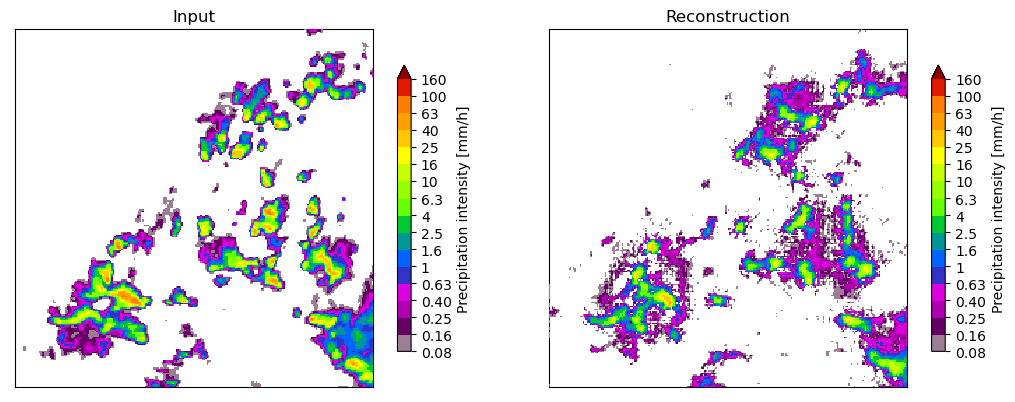

MSE: 11.657 MAE: 0.737 PCC: 0.602 
 CSI(1mm): 0.441 CSI(2mm): 0.391 CSI(8mm): 0.225 
 ACC(1mm): 0.932 ACC(2mm): 0.95 ACC(8mm): 0.976 
 FSS(1km): 0.924 FSS(10km): 0.897 FSS(20km): 0.844 FSS(30km): 0.677


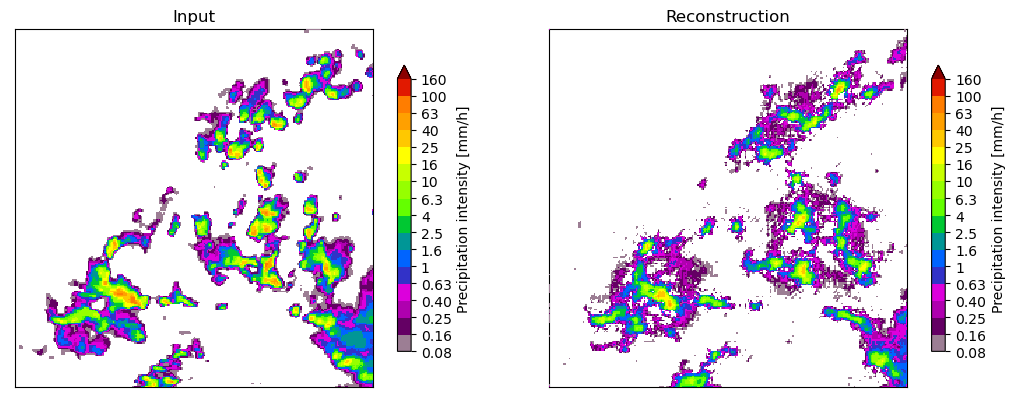

MSE: 2.259 MAE: 0.375 PCC: 0.746 
 CSI(1mm): 0.559 CSI(2mm): 0.456 CSI(8mm): 0.226 
 ACC(1mm): 0.919 ACC(2mm): 0.948 ACC(8mm): 0.991 
 FSS(1km): 0.969 FSS(10km): 0.955 FSS(20km): 0.93 FSS(30km): 0.852


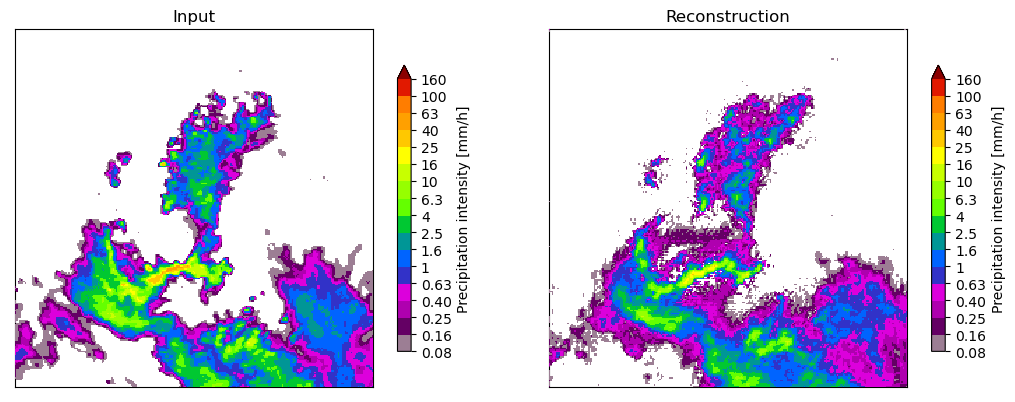

MSE: 10.992 MAE: 0.695 PCC: 0.636 
 CSI(1mm): 0.431 CSI(2mm): 0.403 CSI(8mm): 0.264 
 ACC(1mm): 0.939 ACC(2mm): 0.956 ACC(8mm): 0.978 
 FSS(1km): 0.936 FSS(10km): 0.911 FSS(20km): 0.855 FSS(30km): 0.666


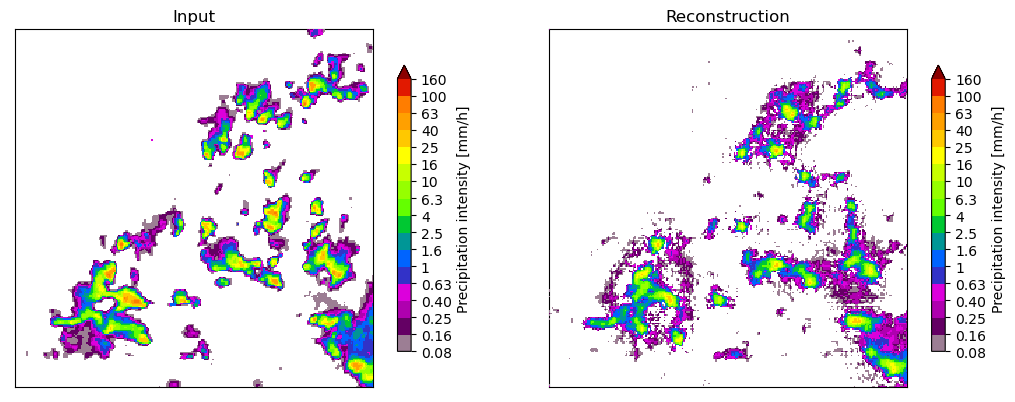

MSE: 9.416 MAE: 0.636 PCC: 0.685 
 CSI(1mm): 0.453 CSI(2mm): 0.418 CSI(8mm): 0.263 
 ACC(1mm): 0.944 ACC(2mm): 0.959 ACC(8mm): 0.979 
 FSS(1km): 0.926 FSS(10km): 0.903 FSS(20km): 0.853 FSS(30km): 0.664


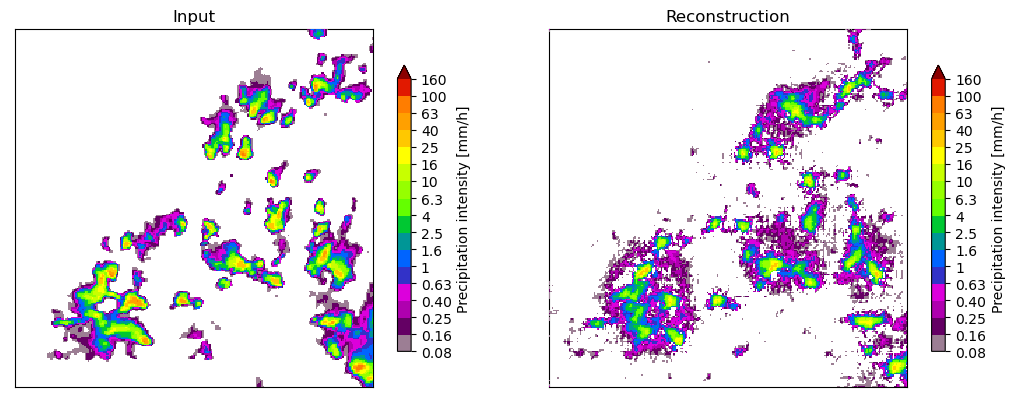

pcc_average: 0.6676


In [14]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_8/vqvae_checkpoint_epoch40', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4, :, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_r_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

In [ ]:
print(input_image.shape)
print(images.shape)

In [ ]:
import numpy as np

# Load the NumPy array from file
array = np.load('/space/ankushroy/Tokeniser_Chkpts_recon_tokens_1024/metrices.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

plt.plot(epochs, total_losses, label='Total Loss')
#plt.plot(epochs, commitment_losses, label='Commitment Loss')
#plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
#plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()
